# Tutorial 4, Integration and downstream of spatial transcriptomics and proteomics of COAD

In [1]:
import sys
sys.path.append(r"/home/wangheqi/PycharmProject/")

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np

import matplotlib.pyplot as plt
import spcoral
import random
import torch

random.seed(2030)
np.random.seed(2030)

### Read the data

The dataset was downloaded from [SPATCH](https://spatch.pku-genomics.org/).

We selected the COAD dataset with transcriptomics (CosMx, 6175 genes) and proteomics (CODEX, 16 proteins) to test SPCoral. 

In [2]:
adata_codex = sc.read_h5ad('/mnt/TrueNas/project/wangheqi_metabolomic_algorithms/CosMx/COAD/proteome/adata_codex.h5ad')
adata_cosmx = sc.read_h5ad('/mnt/TrueNas/project/wangheqi_metabolomic_algorithms/CosMx/COAD/transcriptome/adata.h5ad')

In [3]:
adata_codex = adata_codex[~pd.isna(adata_codex.obs['spatial_cluster']), ].copy()
adata_cosmx = adata_cosmx[~pd.isna(adata_cosmx.obs['spatial_cluster']), ].copy()

### Show cell types of the raw data

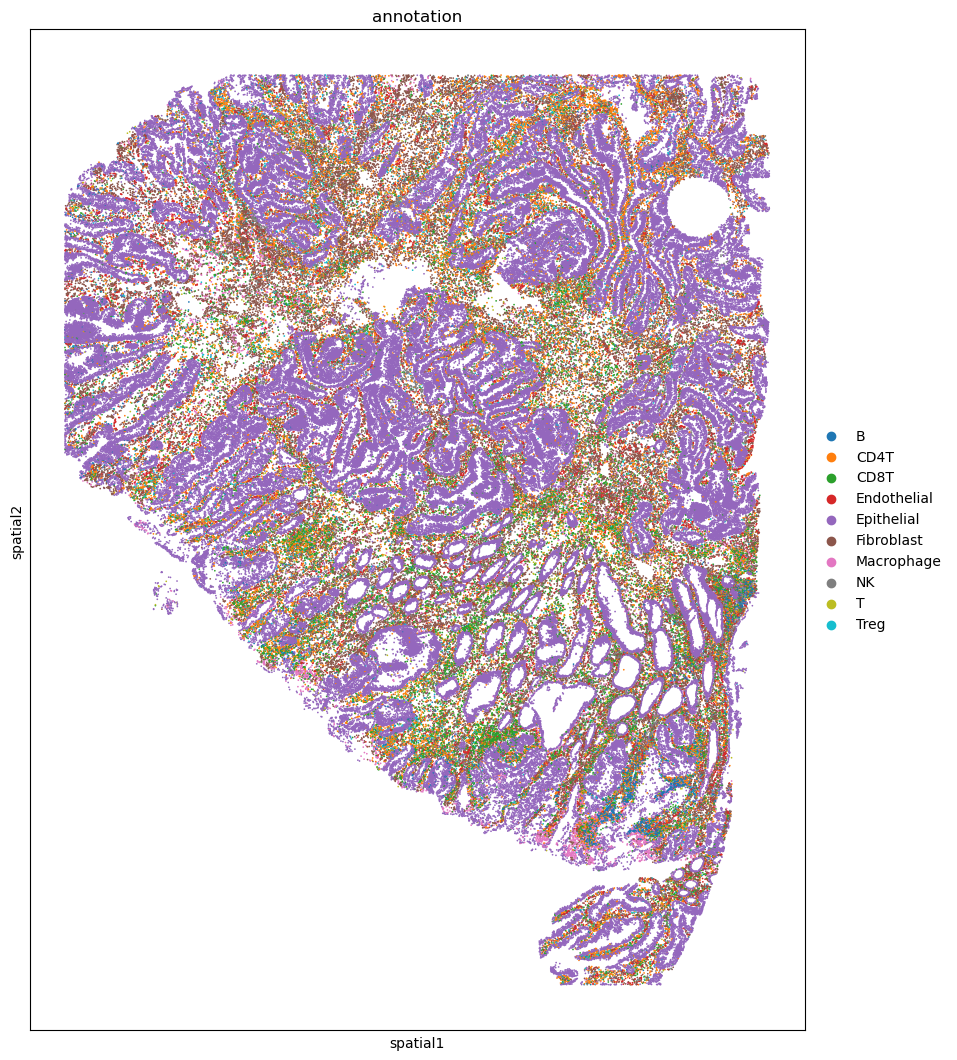

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 13))

sc.pl.embedding(adata_codex, basis='spatial', color='annotation', ax=ax, s=6)

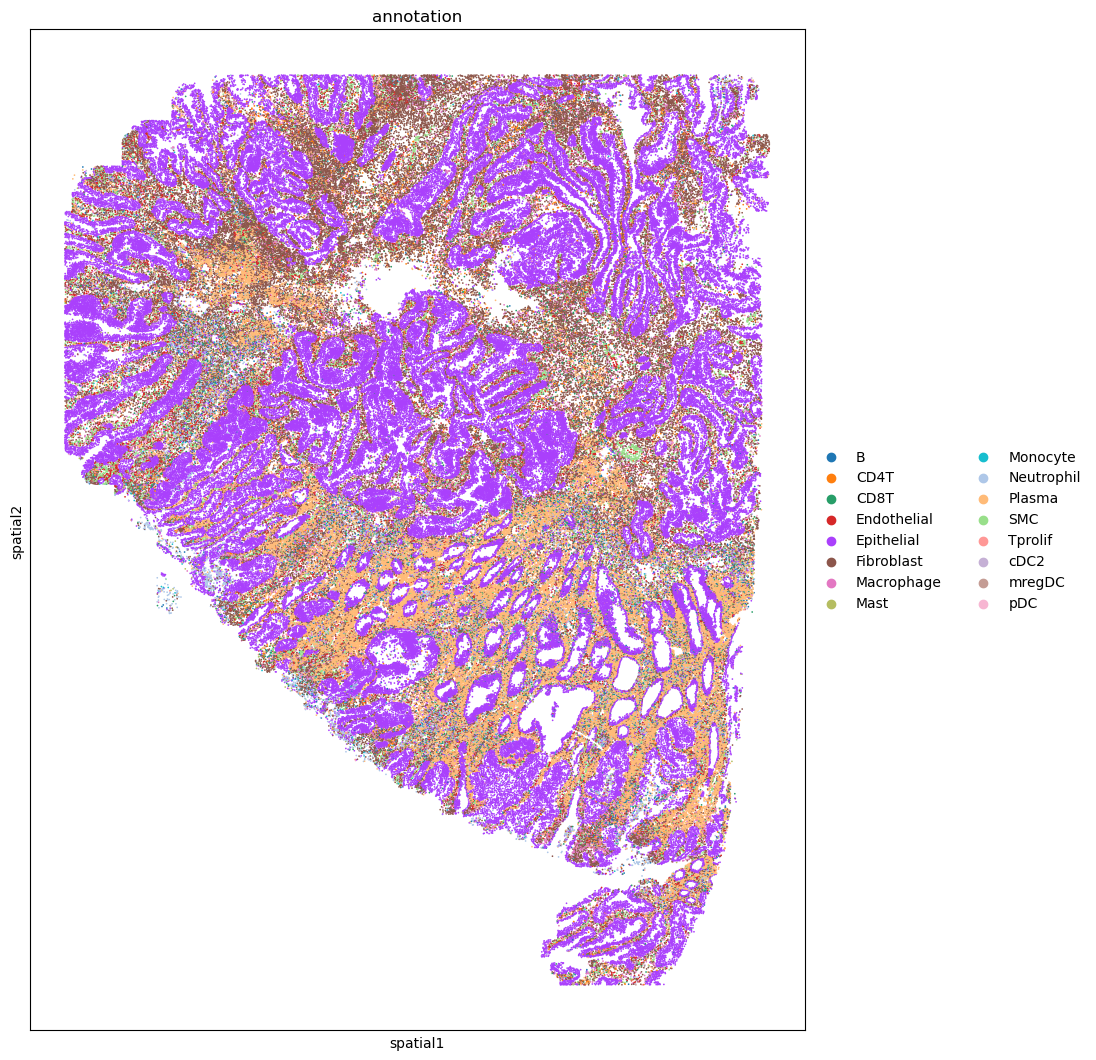

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 13))

sc.pl.embedding(adata_cosmx, basis='spatial', color='annotation', ax=ax, s=6)

### Preprocess 1: Scale the data

In [6]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_cosmx)
# Logarithmize the data
sc.pp.log1p(adata_cosmx)

In [7]:
sc.pp.pca(adata_cosmx, n_comps=100)
sc.pp.scale(adata_codex, max_value=5)

In [8]:
adata_cosmx.obsm['feat'] = adata_cosmx.obsm['X_pca']
adata_codex.obsm['feat'] = adata_codex.X

### Preprocess 2: Segmentation

This dataset contains more than 500,000 cells (CODEX: 248470, CosMx: 261731). After constructing the adjacency network, it is difficult to load it directly into the GPU. To address this, we developed a method similar to patch segmentation, dividing the original data into smaller patches and feeding them into the model one by one.

In [9]:
clip_results = spcoral.pp.clipping_patch(
    adata_omics1 = adata_cosmx,
    adata_omics2 = adata_codex,
    x_num=16,
    y_num=16,
    retain_edge=0.02,
    min_cells=50
)

### Model training

In [10]:
Model = spcoral.model.integrate_model_block(
    clip_results,
    epochs=100,
    device=torch.device('cuda:2'),
)

[Fast Mode] Seed=2020, cudnn.benchmark=True, multi-thread ON


In [11]:
Model.preprocess(
    graph_method_single='radius',
    radius_spatial_omics1=2,
    radius_spatial_omics2=2,
    num_processes=20,
    k_cross_omics=6,
    k_all_omics=12,
    use_obsm='spatial',
    g_all_auto=False
)

Preprocessing blocks with 20 processes: 100%|███████████████████████████████████████████████████████| 256/256 [39:17<00:00,  9.21s/it]


In [12]:
Model.train()

[Fast Mode] Seed=2020, cudnn.benchmark=True, multi-thread ON


Inference blocks: 100%|█████████████████████████████████████████████████████████████████████████████| 203/203 [00:41<00:00,  4.84it/s]


In [13]:
adata_cosmx, adata_codex = Model.map_results_to_adata()

Mapping blocks: 100%|███████████████████████████████████████████████████████████████████████████████| 203/203 [00:03<00:00, 51.02it/s]


In [14]:
adata_cosmx, adata_codex = spcoral.analysis.cluster(adata_cosmx, adata_codex, cluster_method='louvain', resolution_louvain=1.0)

### Visualization

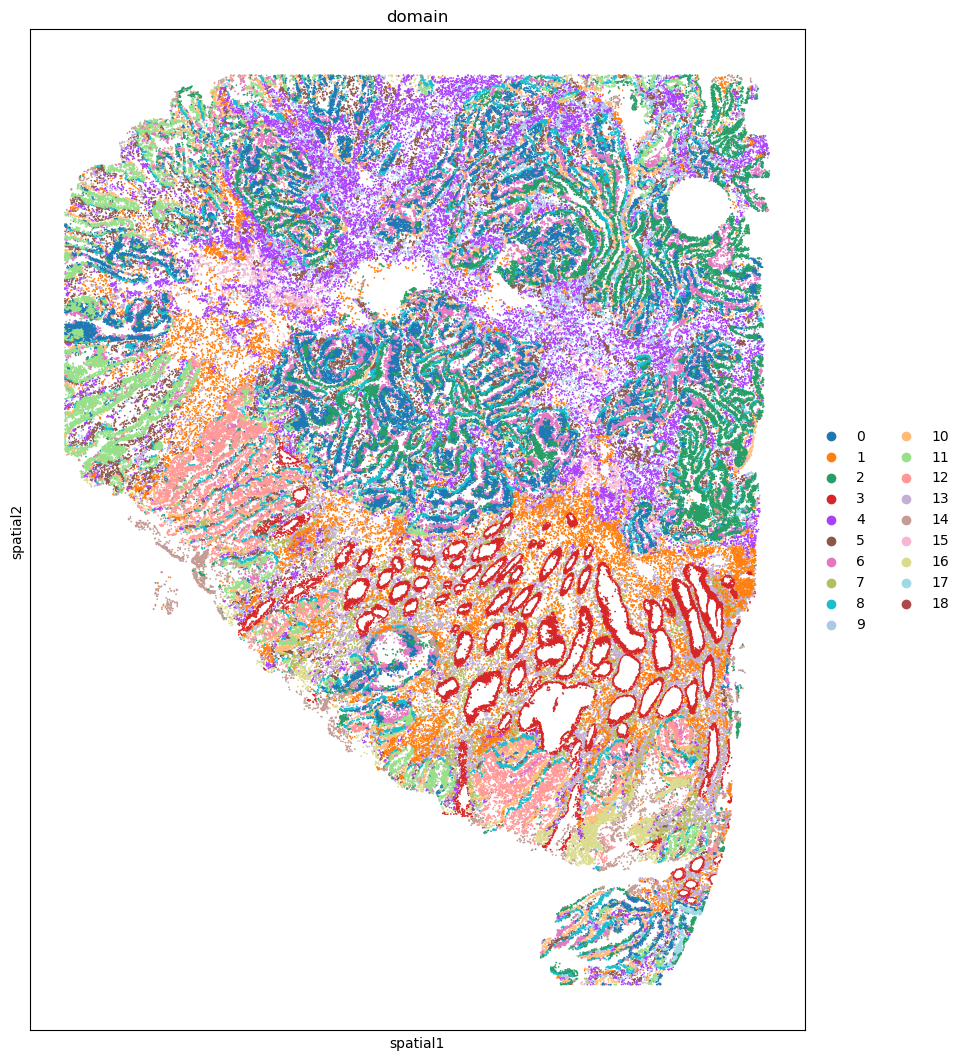

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 13))

sc.pl.embedding(adata_codex, basis='spatial', color='domain', ax=ax, s=6)

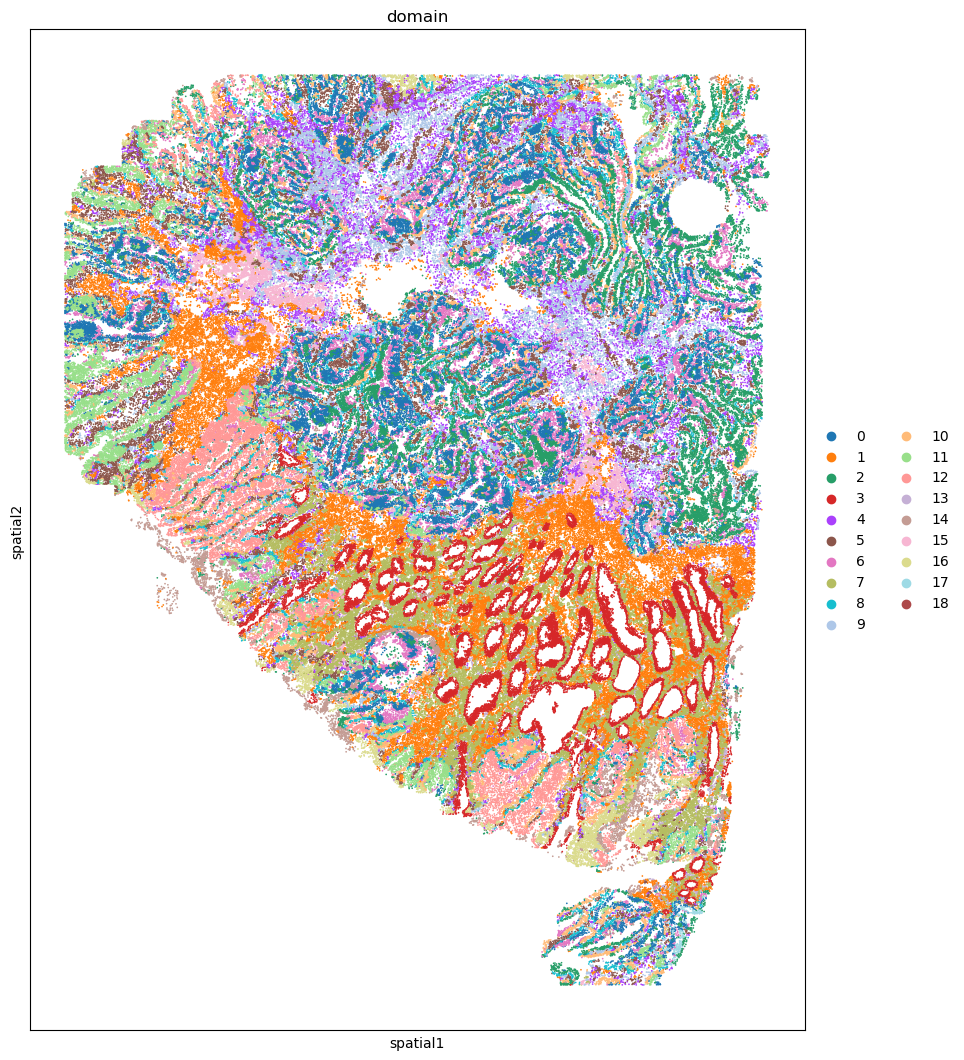

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 13))

sc.pl.embedding(adata_cosmx, basis='spatial', color='domain', ax=ax, s=6)

### Downstream 1: Interpolation & Prediction

Based on the cross decoder of SPCoral, it can perform interpolation and prediction of features between two omics.

Here we present an example of predicting proteomic features in transcriptome slices.

In [17]:
adata_codex_prediction = sc.AnnData(adata_cosmx.obsm['cross_spcoral'], obs=adata_cosmx.obs, var=adata_codex.var, obsm=adata_cosmx.obsm)

In [21]:
adata_codex_prediction.var_names.tolist()

['CD8',
 'CD20',
 'CD3e',
 'CD56',
 'Pan-Cytokeratin',
 'CD4',
 'CD34',
 'SMA',
 'FOXP3',
 'CD163',
 'HLA-A',
 'CD11c',
 'MPO',
 'CD68',
 'HLA-DR',
 'IDO1']

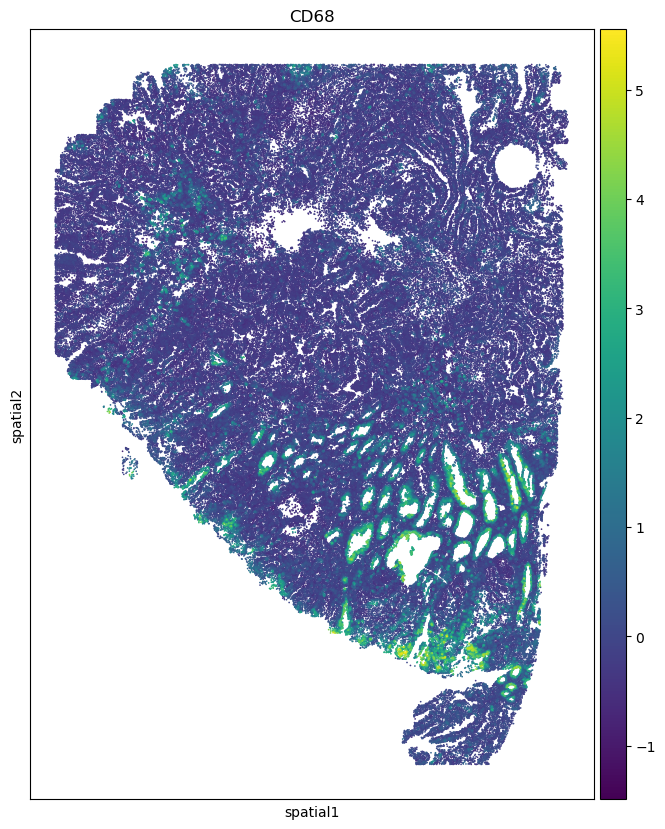

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 10))

sc.pl.embedding(adata_codex_prediction, basis='spatial', color='CD68', ax=ax, s=6)

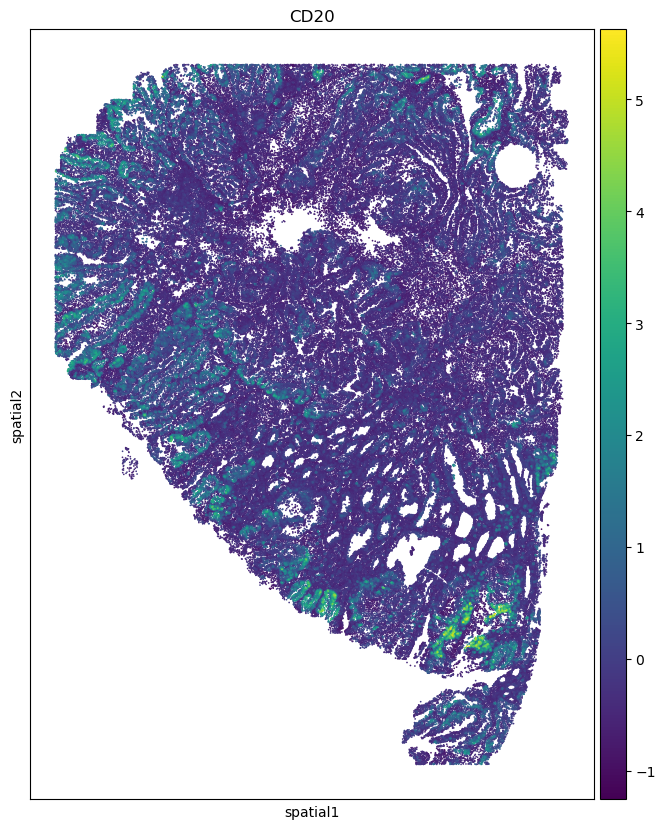

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 10))

sc.pl.embedding(adata_codex_prediction, basis='spatial', color='CD20', ax=ax, s=6)

### Downstream 2: Correlation of cross-model features 

By utilizing the predicted features, we can calculate the correlation between the two omics data sets using various methods.

First, we calculated the global spatial correlation of the characteristic gene SPP1 and the marker protein CD68 in macrophages.

In [28]:
adata_cosmx.X = adata_cosmx.X.toarray()
spcoral.analysis.pearson(adata_cosmx, adata_codex, features_omics1='SPP1', features_omics2='CD68', used_rec=False)

{'features_omics1': ['SPP1'],
 'features_omics2': ['CD68'],
 'SPP1_CD68': {'P': 7.364066971998629e-13, 'corr': 0.014300842633701228}}

In [29]:
spcoral.analysis.bivariate_moran(adata_cosmx, adata_codex, features_omics1='SPP1', features_omics2='CD68', used_rec=False)

{'features_omics1': ['SPP1'],
 'features_omics2': ['CD68'],
 'SPP1_CD68': {'P': 0.001, 'I': 0.013148575831596034}}

Next, we used the local Moran index to identify the spatial locations with strong co-localization between two markers.

In [30]:
res_dict = spcoral.analysis.bivariate_local_moran(
    adata_cosmx, adata_codex, features_omics1='SPP1', features_omics2='CD68', used_rec=False
)

In [31]:
adata_cosmx.obs['SPP1_CD68'] = res_dict['SPP1_CD68']['I']

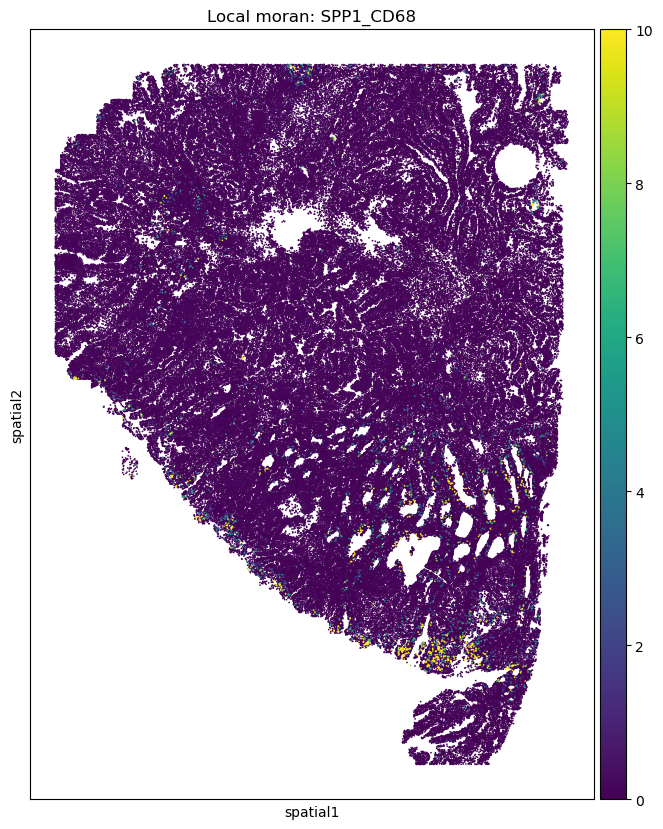

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 10))

sc.pl.embedding(adata_cosmx, basis='spatial', color='SPP1_CD68', ax=ax, s=6, vmin=0, vmax=10, title='Local moran: SPP1_CD68')